In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from glob import glob
import pandas as pd
import pickle
from torch.utils.data import RandomSampler
import random
import scipy
import torch.nn.functional as F
from PIL import Image
from glob import glob
import wandb
import re
from adjustText import adjust_text
import seaborn as sns
import scipy
import statannot
import argparse
import sys
#print(glob('../../*'))
sys.path.append('../../modified_medsam_repo')
from MedSAM_HCP.utils_hcp import *
from MedSAM_HCP.dataset import *
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from MedSAM_HCP.MedSAM import convert_logits_to_preds_onehot

/gpfs/home/kn2347/.conda/envs/medsam/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#path='/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/medsam_vit_b.pth'
#problematic_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/main_analysis_12-18-24/MedSAM_Oracle/training/1_old/0.0005/singletask_medsam_no_yolo-label1_lr0.0005_diceloss_oracle-20241221-153946/medsam_model_best_sam_readable.pth'
#path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/subset_analysis_11-12-24/MedSAM_Oracle/training/0.0005/1/891/0/singletask_medsam_no_yolo-With_Oracle_label1_lr0.0005_subset_891_repeat0-20241126-033405/medsam_model_best_sam_readable.pth'
#path = '/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/segment_anything/sam_vit_b_01ec64.pth'
#path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/main_analysis_12-18-24/MedSAM_YOLO/training/1/0.0005/singletask_medsam_with_yolo-label1_with_yolo_bbox_main_run-20241218-173101/medsam_model_best_sam_readable.pth'
#normal_model_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/main_analysis_12-18-24/MedSAM/training/1/0.0005/singletask_medsam_no_yolo-label1_lr0.0005_diceloss-20241220-125307/medsam_model_best_sam_readable.pth'
#path = problematic_path
#path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/main_analysis_12-18-24/MedSAM_Oracle/training/7_old/0.0005/singletask_medsam_no_yolo-label7_lr0.0005_diceloss_oracle-20241221-173012/medsam_model_best_sam_readable.pth'
#unet_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/path_df_unet.csv'

#sam_model = build_sam_vit_b_multiclass(3, checkpoint=path).to('cuda')
#sam_model.eval()

path = '/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/medsam_vit_b.pth'

sam_model = build_sam_vit_b_multiclass(3, checkpoint=path).to('cuda')
sam_model.eval()

medsam_model = MedSAM(image_encoder=sam_model.image_encoder, 
                        mask_decoder=sam_model.mask_decoder,
                        prompt_encoder=sam_model.prompt_encoder,
                        multimask_output= True # 2 because unknown class is also present in single-task case
                    ).cuda()

In [48]:
label=2

path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/path_df_constant_bbox.csv'
path_to_box_df = f'/gpfs/data/luilab/karthik/pediatric_seg_proj/per_class_isolated_df_new/{label}/0.1/isolated_path_df_bboxes_from_ground_truth.csv'
#path_to_box_df = path
#path_to_box_df = f'/gpfs/data/luilab/karthik/pediatric_seg_proj/per_class_isolated_df_new/yolov10/100/{label}/path_df_only_with_bbox_yolov10.csv'

df_hcp = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/hcp_mapping_processed.csv')
df_desired = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/darts_name_class_mapping_processed.csv')
label_converter = LabelConverter(df_hcp, df_desired)


num_classes=1
train, val, test = load_datasets(
            path_to_box_df,
            '/gpfs/data/luilab/karthik/pediatric_seg_proj/train_val_test_split.pickle',
            label_id = label, bbox_shift=0, 
                sample_n_slices = None, label_converter=label_converter, NUM_CLASSES=num_classes, 
                as_one_hot=True, pool_labels=False)
train_loader = DataLoader(train, batch_size=1, shuffle=False, num_workers=1)

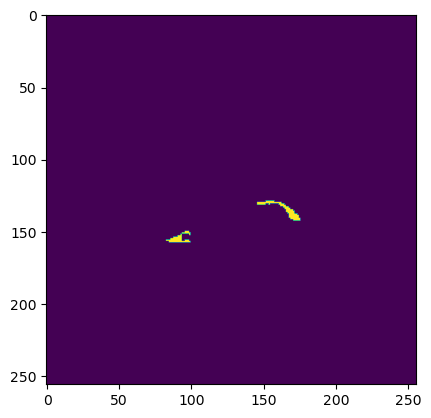

In [65]:
#plt.imshow(train[30][1][0,:,:])
#plt.imshow(train[110][1][0,:,:])
plt.imshow(train[135][1][0,:,:])

In [66]:
for step, (image, gt2D, boxes, sli) in enumerate(tqdm(train_loader)):

    if step != 135:
        continue
    #fac=0
    #boxes[0,0] += fac
    #boxes[0,2] += fac
    image = image.to('cuda')
    gt2D = gt2D.to('cuda') # B x C x H x W
    boxes = boxes.to('cuda')
    #z = sam_model(image, boxes)
    #z = sam_model(image, multimask_output=False)

    #z = medsam_model(image, boxes) 
    #z = convert_logits_to_preds_onehot(z, True, H=256, W=256)
    #z = torch.as_tensor(z, dtype=float)
    
    ze = torch.as_tensor(
            medsam_inference(sam_model, image, boxes, 256, 256, as_one_hot=True,
            model_trained_on_multi_label=False, num_classes = 1)
        ).cuda()
    
    
    break

  0%|          | 135/46246 [00:05<29:27, 26.08it/s] 


(1, 3, 256, 256)


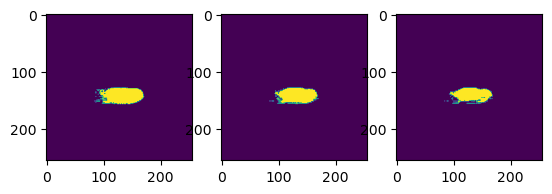

In [67]:
out = medsam_model(image, boxes)
out = convert_logits_to_preds_onehot(out, True, H=256, W=256)
print(out.shape)
fig, axs = plt.subplots(1,3, squeeze=False)
for i in range(3):
    axs[0, i].imshow(out[0, i, :, :])

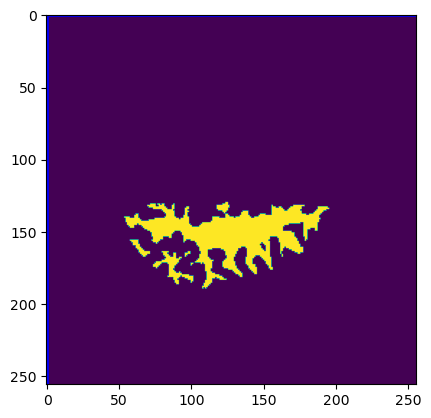

In [289]:
plt.imshow(ze.detach().cpu().numpy()[0,0,:,:])
#plt.imshow(z[0,0,:,:])
show_box(boxes.cpu().numpy().ravel(), plt.gca(), color = 'blue')

### Check SAM Oracle models from subset analysis


In [15]:
#path='/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/medsam_vit_b.pth'
#problematic_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/main_analysis_12-18-24/MedSAM_Oracle/training/1_old/0.0005/singletask_medsam_no_yolo-label1_lr0.0005_diceloss_oracle-20241221-153946/medsam_model_best_sam_readable.pth'
#path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/subset_analysis_11-12-24/MedSAM_Oracle/training/0.0005/1/891/0/singletask_medsam_no_yolo-With_Oracle_label1_lr0.0005_subset_891_repeat0-20241126-033405/medsam_model_best_sam_readable.pth'
#path = '/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/segment_anything/sam_vit_b_01ec64.pth'
#path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/main_analysis_12-18-24/MedSAM_YOLO/training/1/0.0005/singletask_medsam_with_yolo-label1_with_yolo_bbox_main_run-20241218-173101/medsam_model_best_sam_readable.pth'
#normal_model_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/main_analysis_12-18-24/MedSAM/training/1/0.0005/singletask_medsam_no_yolo-label1_lr0.0005_diceloss-20241220-125307/medsam_model_best_sam_readable.pth'
#path = problematic_path
#path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/main_analysis_12-18-24/MedSAM_Oracle/training/7_old/0.0005/singletask_medsam_no_yolo-label7_lr0.0005_diceloss_oracle-20241221-173012/medsam_model_best_sam_readable.pth'
#unet_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/path_df_unet.csv'

#sam_model = build_sam_vit_b_multiclass(3, checkpoint=path).to('cuda')
#sam_model.eval()

path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/subset_analysis_12-21-24/SAM_Oracle_Noised/training/0.0001/1/250/3/singletask_medsam_no_yolo-SAM_Oracle_SUBSET_label1_lr0.0001_subset_250_repeat3-20250324-125105/medsam_model_best_sam_readable.pth'

sam_model = build_sam_vit_b_multiclass(3, checkpoint=path).cuda()
sam_model.eval()

medsam_model = MedSAM(image_encoder=sam_model.image_encoder, 
                        mask_decoder=sam_model.mask_decoder,
                        prompt_encoder=sam_model.prompt_encoder,
                        multimask_output= True # 2 because unknown class is also present in single-task case
                    ).cuda()

In [45]:
label=1

path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/other_path_dfs/path_df_SAM_constant_bbox.csv'
path_to_box_df = f'/gpfs/data/luilab/karthik/pediatric_seg_proj/per_class_isolated_df_new/{label}/0.1/isolated_path_df_SAM_bboxes_from_ground_truth.csv'
#path_to_box_df = path
#path_to_box_df = f'/gpfs/data/luilab/karthik/pediatric_seg_proj/per_class_isolated_df_new/yolov10/100/{label}/path_df_only_with_bbox_yolov10.csv'

df_hcp = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/hcp_mapping_processed.csv')
df_desired = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/darts_name_class_mapping_processed.csv')
label_converter = LabelConverter(df_hcp, df_desired)


num_classes=1
train, val, test = load_datasets(
            path_to_box_df,
            '/gpfs/data/luilab/karthik/pediatric_seg_proj/train_val_test_split.pickle',
            label_id = label, bbox_shift=10, 
                sample_n_slices = None, label_converter=label_converter, NUM_CLASSES=num_classes, 
                as_one_hot=True, pool_labels=False)
train_loader = DataLoader(train, batch_size=1, shuffle=False, num_workers=1)

In [47]:
for step, (image, gt2D, boxes, sli) in enumerate(tqdm(train_loader)):

    if step != 185:
        continue
    #fac=0
    #boxes[0,0] += fac
    #boxes[0,2] += fac
    image = image.to('cuda')
    gt2D = gt2D.to('cuda') # B x C x H x W
    boxes = boxes.to('cuda')
    #z = sam_model(image, boxes)
    #z = sam_model(image, multimask_output=False)

    #z = medsam_model(image, boxes) 
    #z = convert_logits_to_preds_onehot(z, True, H=256, W=256)
    #z = torch.as_tensor(z, dtype=float)
    
    ze = torch.as_tensor(
            medsam_inference(sam_model, image, boxes, 256, 256, as_one_hot=True,
            model_trained_on_multi_label=False, num_classes = 1)
        ).cuda()
    
    
    break

  0%|          | 185/110197 [00:15<2:29:46, 12.24it/s]


In [ ]:
ze = torch.as_tensor(
    medsam_inference(sam_model, image, box2, 256, 256, as_one_hot=True,
    model_trained_on_multi_label=False, num_classes = 1)
).cuda()

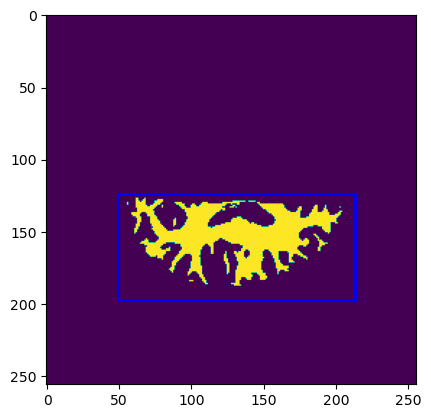

In [48]:
plt.imshow(ze.detach().cpu().numpy()[0,0,:,:])
#plt.imshow(z[0,0,:,:])
show_box(boxes.cpu().numpy().ravel(), plt.gca(), color = 'blue')

In [49]:

p1 = '/gpfs/data/luilab/karthik/pediatric_seg_proj/per_class_isolated_df_new/1/0.1/isolated_path_df_SAM_bboxes_from_ground_truth.csv'
p2 = '/gpfs/data/luilab/karthik/pediatric_seg_proj/per_class_isolated_df_new/1/0.1/isolated_path_df_bboxes_from_ground_truth.csv'

x1 = pd.read_csv(p1)
x2 = pd.read_csv(p2)

In [50]:
x1

,id,slice,image_embedding_slice_path,segmentation_slice_path,image_path,bbox_0,bbox_1,bbox_2,bbox_3
0,100206,4,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/SA...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,NaN,NaN,NaN,NaN
1,100206,28,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/SA...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,NaN,NaN,NaN,NaN
2,100206,46,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/SA...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,NaN,NaN,NaN,NaN
3,100206,47,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/SA...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,NaN,NaN,NaN,NaN
4,100206,58,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/SA...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
137390,996782,189,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/SA...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,140.0,149.0,144.0,158.0
137391,996782,230,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/SA...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,NaN,NaN,NaN,NaN
137392,996782,233,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/SA...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,NaN,NaN,NaN,NaN
137393,996782,243,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/SA...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,NaN,NaN,NaN,NaN


In [51]:
x2

,id,slice,image_embedding_slice_path,segmentation_slice_path,image_path,bbox_0,bbox_1,bbox_2,bbox_3
0,100206,4,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pr...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,NaN,NaN,NaN,NaN
1,100206,28,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pr...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,NaN,NaN,NaN,NaN
2,100206,46,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pr...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,NaN,NaN,NaN,NaN
3,100206,47,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pr...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,NaN,NaN,NaN,NaN
4,100206,58,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pr...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
137390,996782,189,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pr...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,140.0,149.0,144.0,158.0
137391,996782,230,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pr...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,NaN,NaN,NaN,NaN
137392,996782,233,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pr...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,NaN,NaN,NaN,NaN
137393,996782,243,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pr...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,NaN,NaN,NaN,NaN
